In [1]:
import os

import itertools # To join a list of lists

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

Train dataset has N = 28709 samples
Test dataset has N = 3589 samples
Validation dataset has N = 3589 samples

Labels corresponding to randomly drawn images from the training set:
surprise	 happy	 sad  	 surprise	 sad  	 surprise	 angry	 happy	


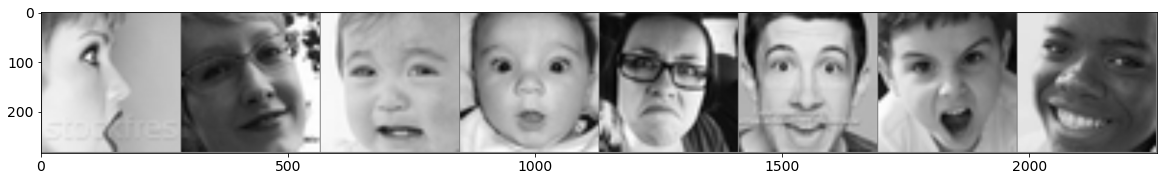

In [2]:
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([280,280]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # 0.5 due to how torchvision data is in range [0,1]
    ])
# Specify the batch size for SGD
batch_size = 64

# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
train_dataset = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root='data/val', transform=transform)

classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
print("Train dataset has N = {} samples".format(len(train_dataset)))
print("Test dataset has N = {} samples".format(len(test_dataset)))
print("Validation dataset has N = {} samples".format(len(valid_dataset)))

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Plotting stuff for visualization ###
fig = plt.figure(figsize=(20,20))
# Utility function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    
# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()

# Show 8 images for display
num_display = 8
imshow(torchvision.utils.make_grid(images[:num_display]))
# Print labels as a concatenated string
print("\nLabels corresponding to randomly drawn images from the training set:")
print(" ".join(f'{classes[labels[j]]:5s}\t' for j in range(num_display)))

In [3]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, padding='same')
        self.drop = nn.Dropout(p=0.2)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same')
        self.fc1 = nn.Linear(num_filters*2*70*70, num_filters)
        self.fc2 = nn.Linear(num_filters, out_classes)

    def forward(self, x):
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 280x280 image -> 140x140 after pooling
        x = self.pool(self.drop(F.relu(self.conv1(x))))
        # 140x140 feature map -> 70x70 after pooling
        x = self.pool(self.drop(F.relu(self.conv2(x))))
        # Flatten all dimensions except batch (start_dim=1)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

input_channels = images.shape[1]
model = ConvNet(input_channels, num_filters=16, out_classes=len(classes))
# Dummy inputs so we can plot a summary of the neural network's architecture and no. of parameters
summary(model, input_size=(input_channels, 280, 280))

# Double check if model exists
if os.path.exists(os.getcwd() + '/cnn_fmd.pth'):
    model.load_state_dict(torch.load(os.getcwd() + '/cnn_fmd.pth'))
    print("Loaded model from disk!")

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            448
├─Dropout: 1-2                           --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            4,640
├─Linear: 1-5                            2,508,816
├─Linear: 1-6                            119
Total params: 2,514,023
Trainable params: 2,514,023
Non-trainable params: 0


In [4]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    print(f"\nTest Error\n\tAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
criterion = nn.CrossEntropyLoss()
# One is enough for my toy example...
num_epochs = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(model, train_dataloader, criterion, optimizer)
    model_test_loader(model, test_dataloader, criterion)
    
# Saving the model file 'cnn_fmd.pth' to my current working directory (cwd)
print("Saving model to disk!")
torch.save(model.state_dict(), os.getcwd() + '/cnn_fmd.pth')

Epoch 1
-------------------------------
loss: 1.932812  [    0/28709]
loss: 1.770247  [  640/28709]
loss: 1.748942  [ 1280/28709]
loss: 1.794931  [ 1920/28709]
loss: 1.894522  [ 2560/28709]
loss: 1.825609  [ 3200/28709]
loss: 1.735171  [ 3840/28709]
loss: 1.884742  [ 4480/28709]
loss: 1.896731  [ 5120/28709]
loss: 1.728313  [ 5760/28709]
loss: 1.721088  [ 6400/28709]
loss: 1.774771  [ 7040/28709]
loss: 1.727506  [ 7680/28709]
loss: 1.766004  [ 8320/28709]
loss: 1.764872  [ 8960/28709]
loss: 1.697237  [ 9600/28709]
loss: 1.729443  [10240/28709]
loss: 1.747664  [10880/28709]
loss: 1.685804  [11520/28709]
loss: 1.772606  [12160/28709]
loss: 1.739718  [12800/28709]
loss: 1.737385  [13440/28709]
loss: 1.628410  [14080/28709]
loss: 1.894663  [14720/28709]
loss: 1.647992  [15360/28709]
loss: 1.648026  [16000/28709]
loss: 1.735910  [16640/28709]
loss: 1.695156  [17280/28709]
loss: 1.620152  [17920/28709]
loss: 1.706983  [18560/28709]
loss: 1.541007  [19200/28709]
loss: 1.706207  [19840/28709]



GroundTruth:
 neutral	 fear 	 sad  	 happy	 happy	 surprise	 happy	 neutral	

Predicted:
 neutral	 surprise	 neutral	 happy	 fear 	 happy	 happy	 happy	


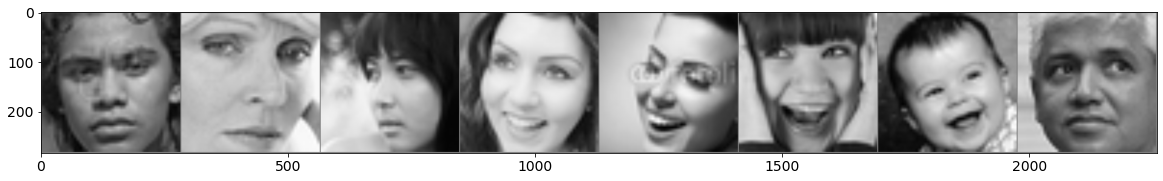

In [5]:
### Plotting stuff ###
fig = plt.figure(figsize=(20,20))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:num_display]))

outputs = model(images)
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

# Print labels
print("\nGroundTruth:\n", " ".join(f'{classes[labels[j]]:5s}\t' for j in range(8)))

print("\nPredicted:\n", " ".join(f'{classes[predicted[j]]:5s}\t' for j in range(8)))

Accuracy of the network on the test set images: 37 %
Confusion Matrix (columns: True class, rows: Predicted class):


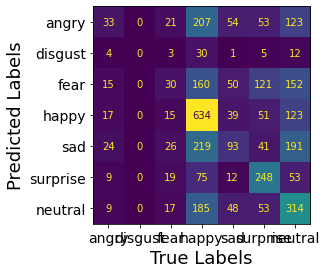

In [7]:
correct = 0

predicted_list = []
labels_list = []

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    i = 0
    for data in test_dataloader:
        i += 1
        images, labels = data
        # Forward pass through network
        outputs = model(images)
        # Take most probable class
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted.detach().numpy())
        labels_list.append(labels.detach().numpy())
        
# Hacky conversions from a list of lists of arrays into joined numpy arrays
predicted_list = np.array(list(itertools.chain.from_iterable(predicted_list)))
labels_list = np.array(list(itertools.chain.from_iterable(labels_list)))
# Count up number of labels and correct predictions
correct = sum(predicted_list == labels_list)

print(f"Accuracy of the network on the test set images: {100 * correct // len(test_dataloader.dataset)} %")

print("Confusion Matrix (columns: True class, rows: Predicted class):")
conf_mat = confusion_matrix(labels_list, predicted_list);
conf_display = ConfusionMatrixDisplay.from_predictions(labels_list, predicted_list, display_labels=classes, colorbar=False);
plt.xlabel("True Labels");
plt.ylabel("Predicted Labels");